In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import math
import mlflow
import optuna
import os

from TMDP import TMDP
from algorithms import *
from model_functions import *
from policy_utils import *
from experiment_result_utils import *
from constants import *

from FrozenLake import *
from CurriculumPMPO import CurriculumPMPO

c:\Users\crist\OneDrive - Politecnico di Milano\Polimi\Tesi\TMDP\env_mlflow\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
is_slippery = False
reward_shape = True
num_bins = 10
checkpoint_step=500
test_episodes = 1000
episodes = 5900000
num_runs = 10
dense_reward = True
shape_range=(-1,0)
goal_reward=1.
debug = False

In [3]:
#Frozen Lake Environment
nrows = 20
nS = nrows**2
nA = 4
gamma = 0.999999999
tau = 0.
xi = np.ones(nS) * 1/nS


In [4]:
run_name = f"PPO_{num_bins}"

mlflow.set_tracking_uri(MLFLOW_URI)
experiment_name = f"FrozenLake_{nrows}x{nrows}_{num_bins}"
experiment_id = get_or_create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

save_path = f"results/{experiment_name}/run_{run_name}"
label = run_name.split("_")[0]

In [5]:

model_lr = 0.43558313546765237
pol_lr = 0.15886643088594296
temp = 36.55181904781457
epochs = 3
entropy_coef = 1.6642224833735186
batch_size = 20
debug = False

final_temp=1
param_decay=False
lam = 1


eps_ppo = 0.2
eps_model = compute_eps_model(gamma, tau, episodes/10)

experiment_results = []
tests_rewards = []

In [6]:
def run_experiment(index, seed, run_name, change_map=False):
    sub_run_name = f"{run_name}_{index}"
    
    with mlflow.start_run(nested=True, run_name=sub_run_name):
        # Environment specific configuration   
        map_seed = seed if change_map else constants.SEEDS[0]
        set_policy_seed(seed)
        env = FrozenLakeEnv(is_slippery=False, seed=seed, 
                        desc=generate_random_map(nrows, seed=map_seed), 
                        reward_shape=True,
                        num_bins=num_bins,
                        dense_reward=dense_reward,
                        shape_range=shape_range,
                        goal_reward=goal_reward,
                        )
        
        # Environment independent configuration
        tmdp = TMDP(env, xi, tau=tau, gamma=gamma, seed=seed)
        tmdp.update_tau(tau)
        curr_PMPO = CurriculumPMPO(tmdp, checkpoint_step=checkpoint_step)

        curr_PMPO.train(model_lr, pol_lr, batch_size=batch_size, 
                lam=lam, temp=temp, final_temp=final_temp,
                episodes=episodes, eps_ppo=eps_ppo,
                eps_model=eps_model,
                param_decay=param_decay, epochs=epochs, max_length=1000,
                entropy_coef=entropy_coef)
        
        avg_reward = np.average(curr_PMPO.reward_records[-10:])/batch_size
        
        
        mlflow.log_metric("Avg Reward", avg_reward)
        
        run_dict = {
            "episodes": curr_PMPO.episodes,
            "model_lr": model_lr,
            "pol_lr": pol_lr,
            "temp": temp,
            "final_temp": final_temp,
            "batch_size": batch_size,
            "epochs": epochs,
            "lam": lam,
            "eps_ppo": eps_ppo,
            "eps_model": eps_model,
        }
        mlflow.log_params(run_dict)
        mlflow.set_tags(tags={
            "run_name": run_name,
            "change_map": change_map,
            "seed": seed,
            "tau": nS,
            "gamma": gamma,
            "checkpoint_step": checkpoint_step,
            "test_episodes": test_episodes,
            "index": index,
            "dense_reward": dense_reward,
            "shape_range": shape_range,
            "goal_reward": goal_reward,
        })

        
        test_rewards = test_policies(tmdp, curr_PMPO.thetas, test_episodes, 1e-5)
        
        result_dict = {
            "thetas" : curr_PMPO.thetas,
            "taus" : curr_PMPO.taus,
            "reward_records" : curr_PMPO.reward_records,
            "test_rewards" : test_rewards,
            "index" : index,
        }

        tests_rewards.append(test_rewards)
        experiment_results.append(result_dict)
        # Save artifact to MLFlow
        try:
            save_to_mlflow(result_dict, run_name)
        except Exception as e:
            print(f"Error saving to MLFlow: {e}")
            print("Saving locally instead.")
            time.sleep(5)
            path = save_path+f"/{sub_run_name}"
            save(path, result_dict)

In [7]:
def run_experiments(change_map=False, num_runs=10):
    with mlflow.start_run(run_name=run_name):
        
        for i in range(num_runs):
            seed = constants.SEEDS[i]
            run_experiment(i, seed, run_name, change_map)
        
        experiment_dict = {
            "tests_rewards": tests_rewards,
            "num_runs": num_runs,
            "change_map": change_map,
            "num_bins": num_bins,
            "label": label,
        }
        try:
            save_to_mlflow(experiment_dict, run_name)
        except Exception as e:
            print(e)
            print("Something went wrong saving the experiment results to MLFlow.")
            print("Saving locally instead.")
            time.sleep(5)
            save(save_path, experiment_dict)

        rewards_fig = plot_avg_test_return(tests_rewards, f"PPO Avg Return on {num_runs} runs")
        try:
            mlflow.log_figure(figure=rewards_fig, artifact_file="reward_image.png")
        except Exception as e:
            print(e)
            print("Something went wrong saving the figure to MLFlow.")
            print("Saving locally instead.")
            time.sleep(5)
            rewards_fig.savefig(save_path+"/reward_image.png")

Current seed for result reproducibility: 2999
Episode: 5000 reward: -8003.799999999999 length: 5
Episode: 10000 reward: -8008.0 length: 6
Episode: 15000 reward: -7820.999999999996 length: 0
Episode: 20000 reward: -7788.7999999999965 length: 3
Episode: 25000 reward: -7696.799999999995 length: 166
Episode: 30000 reward: -7284.199999999993 length: 10
Episode: 35000 reward: -7408.4999999999945 length: 56
Episode: 40000 reward: -7496.999999999994 length: 86
Episode: 45000 reward: -7231.099999999992 length: 98
Episode: 50000 reward: -7252.399999999994 length: 80
Episode: 55000 reward: -7263.2999999999965 length: 70
Episode: 60000 reward: -7136.699999999995 length: 132
Episode: 65000 reward: -7037.399999999994 length: 59
Episode: 70000 reward: -6809.099999999997 length: 12
Episode: 75000 reward: -6556.999999999993 length: 43
Episode: 80000 reward: -6650.799999999996 length: 57
Episode: 85000 reward: -6443.999999999991 length: 153
Episode: 90000 reward: -6437.999999999992 length: 151
Episode: 

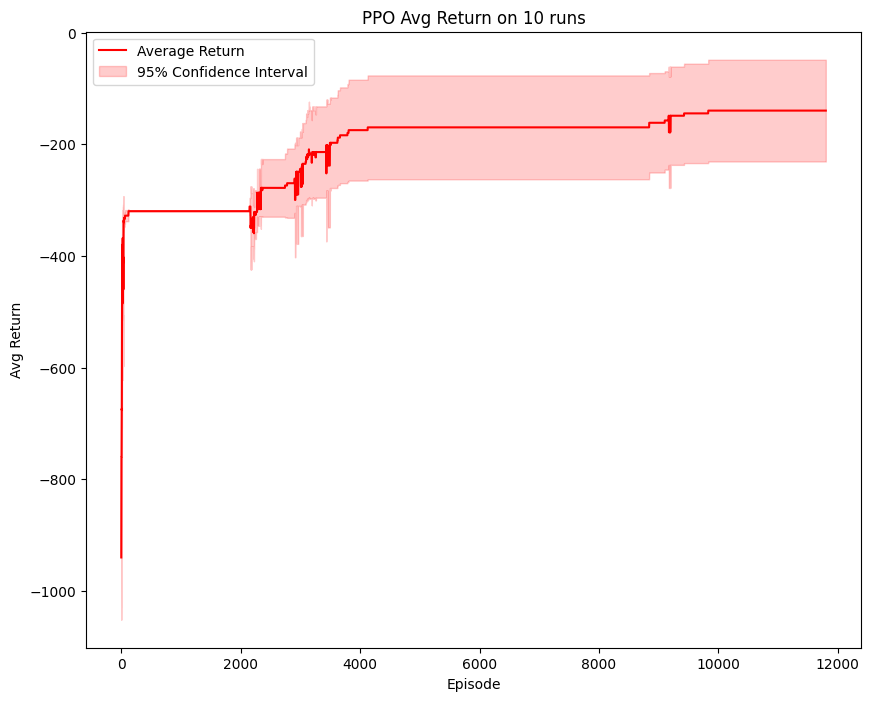

In [8]:
run_experiments(change_map=False, num_runs=num_runs)